In [2]:
from urllib.request import urlopen
import pickle
import numpy
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [3]:
df = pickle.load(urlopen('https://drive.usercontent.google.com/u/0/uc?id=1hN_1LAMCoyRu_WXzSj1k9kOmM98zgiBm&export=download'))
df

,Date,Actual Price,Forecasted Load,Cleared Load,Actual Load,Retail Price(cents/kwhr),kwhrs,Precipitation (in) Chicago,Snowfall (in) Chicago,Max Temp (F) Chicago,...,Precipitation (in) Springfield,Snowfall (in) Springfield,Max Temp (F) Springfield,Min Temp (F) Springfield,Mean Temp (F) Springfield,Average Max Temp (F),Average Min Temp (F),Average Mean Temp (F),Average Precipitation (in),Average Snowfall (in)
0,2023-10-20 16:00:00,41.50,71410,72599,73812,15.75,2.634921,0.0,0.0,61.0,...,0.00,0.0,68.0,45.0,56.5,62.666667,46.333333,54.500000,0.083333,0.0
1,2023-10-20 17:00:00,92.50,71201,73940,73858,15.75,5.873016,0.0,0.0,61.0,...,0.00,0.0,68.0,45.0,56.5,62.666667,46.333333,54.500000,0.083333,0.0
2,2023-10-20 18:00:00,31.93,71200,76048,73281,15.75,2.027302,0.0,0.0,61.0,...,0.00,0.0,68.0,45.0,56.5,62.666667,46.333333,54.500000,0.083333,0.0
3,2023-10-20 19:00:00,26.58,71319,77348,73087,15.75,1.687619,0.0,0.0,61.0,...,0.00,0.0,68.0,45.0,56.5,62.666667,46.333333,54.500000,0.083333,0.0
4,2023-10-20 20:00:00,27.59,70508,73893,71105,15.75,1.751746,0.0,0.0,61.0,...,0.00,0.0,68.0,45.0,56.5,62.666667,46.333333,54.500000,0.083333,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,2024-07-31 18:00:00,50.56,117585,117182,115967,15.35,3.293811,0.0,0.0,92.0,...,0.32,0.0,82.0,70.0,76.0,87.333333,70.000000,78.666667,0.106667,0.0
6428,2024-07-31 19:00:00,27.55,115484,116193,112798,15.35,1.794788,0.0,0.0,92.0,...,0.32,0.0,82.0,70.0,76.0,87.333333,70.000000,78.666667,0.106667,0.0
6429,2024-07-31 20:00:00,32.36,111855,114754,108578,15.35,2.108143,0.0,0.0,92.0,...,0.32,0.0,82.0,70.0,76.0,87.333333,70.000000,78.666667,0.106667,0.0
6430,2024-07-31 21:00:00,35.01,108298,109081,105087,15.35,2.280782,0.0,0.0,92.0,...,0.32,0.0,82.0,70.0,76.0,87.333333,70.000000,78.666667,0.106667,0.0


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

df.dropna(inplace=True)

df.sort_values('Date', inplace=True)

df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Hour'] = df['Date'].dt.hour
df['Season'] = df['Date'].dt.month % 12 // 3 + 1  # winter = 1, spring = 2, summer = 3, fall = 4

In [5]:
features = [
    'Forecasted Load',
    'Cleared Load',
    'Average Max Temp (F)',
    'Average Min Temp (F)',
    'Average Mean Temp (F)',
    'Average Precipitation (in)',
    'Average Snowfall (in)',
    'Month',
    'DayOfWeek',
    'Hour',
    'Season'
]

X = df[features]
y = df['Actual Price']

In [6]:
X_values = X.values
y_values = y.values

groups = df['Month'].values

gss = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [7]:
for train_idx, test_idx in gss.split(X_values, y_values, groups=groups):
    X_train, X_test = X_values[train_idx], X_values[test_idx]
    y_train, y_test = y_values[train_idx], y_values[test_idx]

    # scale the features
    feature_scaler = StandardScaler()
    X_train_scaled = feature_scaler.fit_transform(X_train)
    X_test_scaled = feature_scaler.transform(X_test)

    # scale the target
    target_scaler = MinMaxScaler()
    y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))
    y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

    # built
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    # compile
    model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

In [8]:
history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_test_scaled, y_test_scaled),
        epochs=50,
        batch_size=32,
        verbose=1
    )

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0182 - val_loss: 0.0031
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 9/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 10/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.9145e-04 - val_loss: 0.0023
Epoch 11/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.1376e-04 - val_loss: 0.0021
Epoch 12/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [14]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_actual = target_scaler.inverse_transform(y_test_scaled)

mse = mean_squared_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f'Mean Squared Error: {mse:.2f}')
print(f'R2 Score: {r2:.2f}')

import numpy as np

tolerance = 0.20
relative_error = np.abs(y_actual - y_pred) / y_actual
relative_error = np.where(np.isfinite(relative_error), relative_error, np.inf)
accuracy = np.mean(relative_error <= tolerance) * 100

print(f'Accuracy (within ±5%): {accuracy:.2f}%')

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error: 1263.88
R2 Score: -0.05
Accuracy (within ±5%): 28.87%


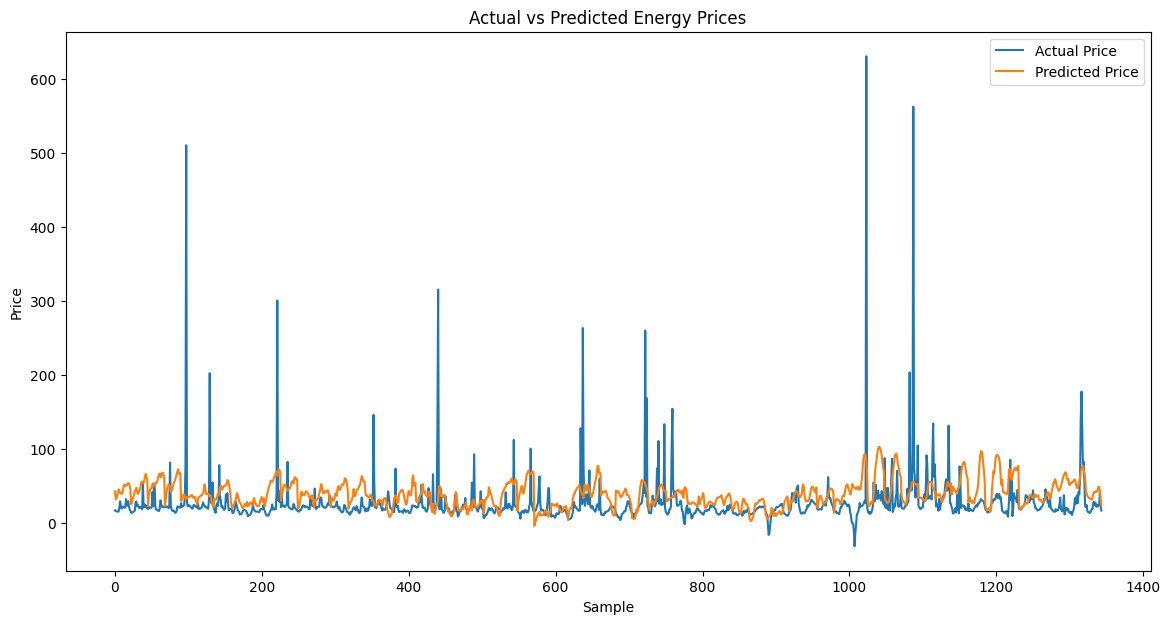

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_actual, label='Actual Price')
plt.plot(y_pred, label='Predicted Price')
plt.title('Actual vs Predicted Energy Prices')
plt.xlabel('Sample')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
batch_sizes = [16, 32, 64, 128, 256]

In [ ]:
results = {}

for batch_size in batch_sizes:
    print(f"\nTraining model with batch size: {batch_size}")

    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mse')

    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_test_scaled, y_test_scaled),
        epochs=50,
        batch_size=batch_size,
        verbose=0
    )

    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_actual = target_scaler.inverse_transform(y_test_scaled)

    mse = mean_squared_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    results[batch_size] = {
        'history': history,
        'mse': mse,
        'r2': r2,
        'y_pred': y_pred
    }

    print(f'Batch Size: {batch_size}, MSE: {mse:.2f}, R² Score: {r2:.2f}')


Training model with batch size: 16


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch Size: 16, MSE: 1250.99, R² Score: -0.04

Training model with batch size: 32


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Batch Size: 32, MSE: 1566.29, R² Score: -0.30

Training model with batch size: 64


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Batch Size: 64, MSE: 1493.88, R² Score: -0.24

Training model with batch size: 128


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Batch Size: 128, MSE: 1899.59, R² Score: -0.58

Training model with batch size: 256


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Batch Size: 256, MSE: 1741.12, R² Score: -0.45


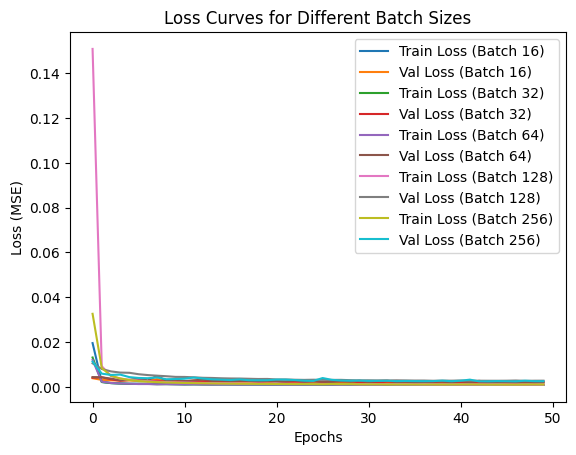

In [ ]:
for batch_size in batch_sizes:
    history = results[batch_size]['history']
    plt.plot(history.history['loss'], label=f'Train Loss (Batch {batch_size})')
    plt.plot(history.history['val_loss'], label=f'Val Loss (Batch {batch_size})')

plt.title('Loss Curves for Different Batch Sizes')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

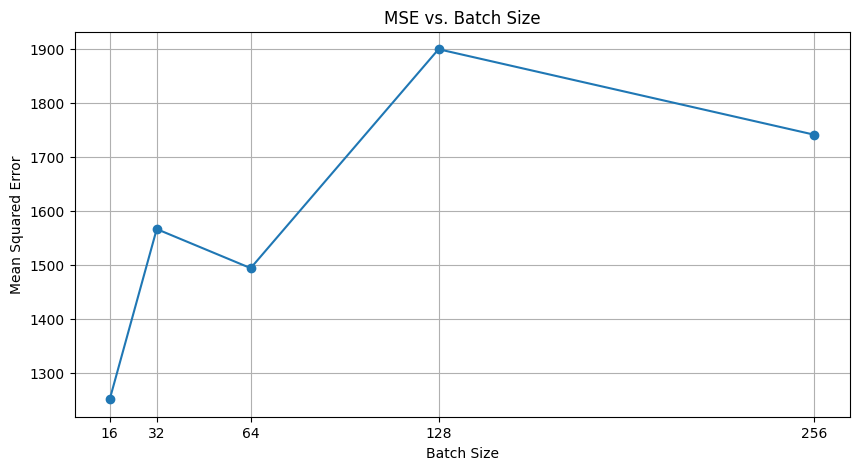

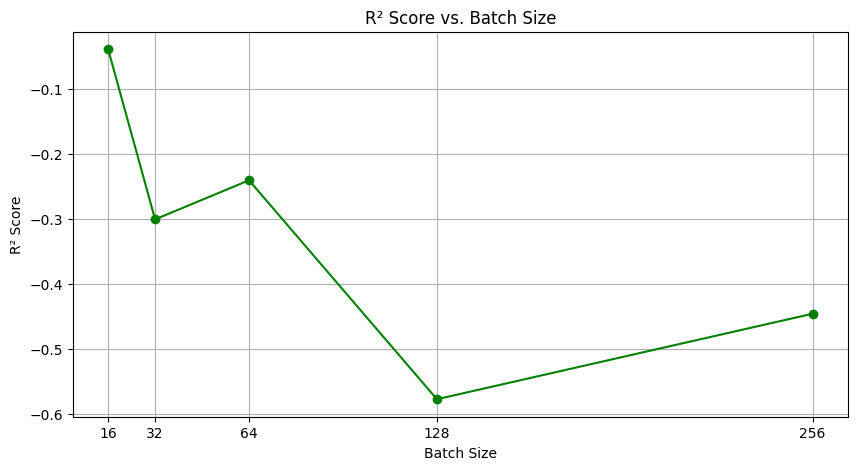

In [ ]:
mse_values = [results[bs]['mse'] for bs in batch_sizes]
r2_values = [results[bs]['r2'] for bs in batch_sizes]

plt.figure(figsize=(10, 5))
plt.plot(batch_sizes, mse_values, marker='o')
plt.title('MSE vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Mean Squared Error')
plt.xticks(batch_sizes)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(batch_sizes, r2_values, marker='o', color='green')
plt.title('R² Score vs. Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('R² Score')
plt.xticks(batch_sizes)
plt.grid(True)
plt.show()

We created a deep learning model using the ADAM optimizer and a batch size = 32. From the 50 epoch iteration using this setup, we discovered diminishing returns after epoch 27.

Next, we experimented with various batch sizes of 16, 32 (baseline), 64, 128 and 256. It was found that reducing the batch sizes resulted in better performance of the deep learning model. However, increasing to 64 yielded marginally poorer performance with significant differences noted at 128.


In [ ]:
optimizers = ['adam', 'sgd']
for opt in optimizers:
    print(f"\nTraining model with optimizer: {opt}")

    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=opt, loss='mse')

    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_test_scaled, y_test_scaled),
        epochs=50,
        batch_size=32,
        verbose=0
    )

    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_actual = target_scaler.inverse_transform(y_test_scaled)

    mse = mean_squared_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    results[opt] = {
        'history': history,
        'mse': mse,
        'r2': r2,
        'y_pred': y_pred
    }

    print(f'Optimizer: {opt}, MSE: {mse:.2f}, R² Score: {r2:.2f}')


Training model with optimizer: adam


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Optimizer: adam, MSE: 1420.67, R² Score: -0.18

Training model with optimizer: sgd


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Optimizer: sgd, MSE: 1596.33, R² Score: -0.33


In [ ]:
results = {}
learning_rate_exps = [-i for i in range(1,6)]
learning_rates = [10**(exp) for exp in learning_rate_exps]
for lr in learning_rates:
    print(f"\nTraining model with learning rate: {lr}")

    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate = lr), loss='mse')

    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_test_scaled, y_test_scaled),
        epochs=50,
        batch_size=32,
        verbose=0
    )

    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = target_scaler.inverse_transform(y_pred_scaled)
    y_actual = target_scaler.inverse_transform(y_test_scaled)

    mse = mean_squared_error(y_actual, y_pred)
    r2 = r2_score(y_actual, y_pred)

    results[lr] = {
        'history': history,
        'mse': mse,
        'r2': r2,
        'y_pred': y_pred
    }

    print(f'Learning Rate: {lr}, MSE: {mse:.2f}, R² Score: {r2:.2f}')


Training model with learning rate: 0.1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Learning Rate: 0.1, MSE: 1224.61, R² Score: -0.02

Training model with learning rate: 0.01


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Learning Rate: 0.01, MSE: 1223.06, R² Score: -0.02

Training model with learning rate: 0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Learning Rate: 0.001, MSE: 1457.58, R² Score: -0.21

Training model with learning rate: 0.0001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Learning Rate: 0.0001, MSE: 1832.33, R² Score: -0.52

Training model with learning rate: 1e-05


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Learning Rate: 1e-05, MSE: 3431.06, R² Score: -1.85


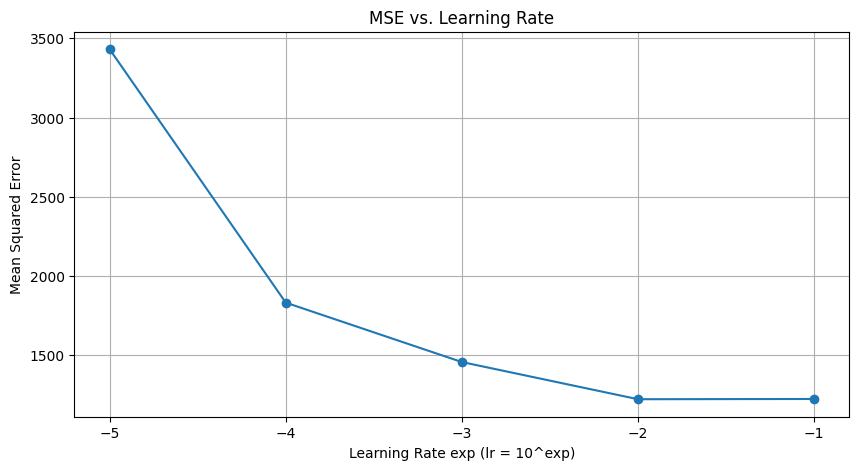

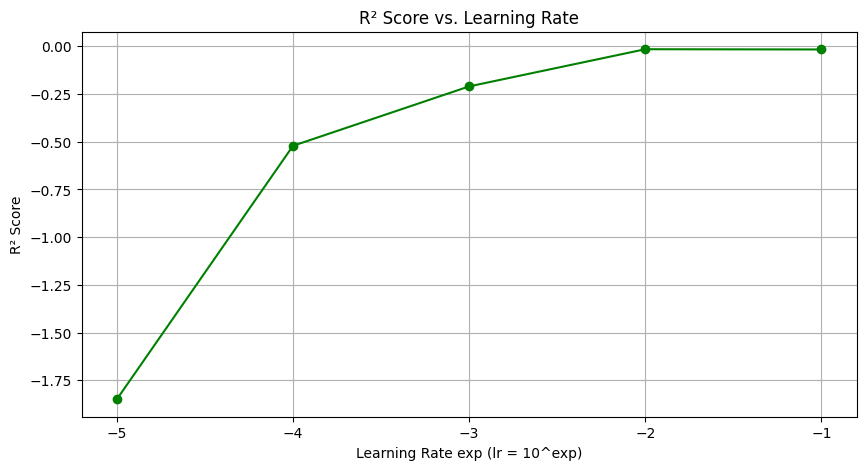

In [ ]:
mse_values = [results[lr]['mse'] for lr in learning_rates]
r2_values = [results[lr]['r2'] for lr in learning_rates]

plt.figure(figsize=(10, 5))
plt.plot(learning_rate_exps, mse_values, marker='o')
plt.title('MSE vs. Learning Rate')
plt.xlabel('Learning Rate exp (lr = 10^exp)')
plt.ylabel('Mean Squared Error')
plt.xticks(learning_rate_exps)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(learning_rate_exps, r2_values, marker='o', color='green')
plt.title('R² Score vs. Learning Rate')
plt.xlabel('Learning Rate exp (lr = 10^exp)')
plt.ylabel('R² Score')
plt.xticks(learning_rate_exps)
plt.grid(True)
plt.show()